# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.multicomp as mc

import os
import json

c:\programdata\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\programdata\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [3]:
sns.set(style = 'whitegrid')

# Load data

In [4]:
data = pd.read_csv(os.path.join(data_path,'clean_data.csv'))
data.head()

,sampleNameOnTube,gender,treatment,tissue,injectionVolume,componentName,massInfo,componentGroupName,expectedRt,area,isArea,areaRatio,retentionTime,signalNoise,tissueWeightMg,normalizedArea,pnd,sampleName,isNormalizationFactor,normfactor
0,C20 M1 S,Male,Control,Striatum,10,SM(18:1)+H_d9_SPLASH.IS,738.7 / 184.2,SM,12.51,6.142877e+07,NaN,NaN,12.514791,141.426257,56,NaN,30,20,True,10
1,C20 M1 S,Male,Control,Striatum,10,SM(14:0)+H,675.5 / 184.1,SM,12.51,4.116176e+06,6.142877e+07,0.067007,12.737513,77.971430,56,0.119656,30,20,False,10
2,C20 M1 S,Male,Control,Striatum,10,SM(16:0)+H,703.6 / 184.1,SM,12.51,2.433723e+07,6.142877e+07,0.396186,12.662914,147.602022,56,0.707475,30,20,False,10
3,C20 M1 S,Male,Control,Striatum,10,SM(18:0)+H,731.6 / 184.1,SM,12.51,1.432478e+08,6.142877e+07,2.331933,12.580159,144.222304,56,4.164166,30,20,False,10
4,C20 M1 S,Male,Control,Striatum,10,SM(18:1)+H,729.6 / 184.1,SM,12.51,1.268323e+08,6.142877e+07,2.064706,12.572303,193.985512,56,3.686974,30,20,False,10


# Manipulate data

Extract log value of the target variable

In [5]:
columns_to_transform = ['normalizedArea','areaRatio']

for c in columns_to_transform:
    data['log'+c[0].capitalize()+c[1:]] = data[c].apply(lambda x: np.log(x))

Drop NaN

In [6]:
print(f'Number of points before NaN removal: {data.shape[0]}')
data.dropna(axis=0, subset=['normalizedArea'], inplace=True)
print(f'Number of after before NaN removal: {data.shape[0]}')

Number of points before NaN removal: 57264
Number of after before NaN removal: 31367


Drop normalization factors

In [7]:


data_normalized = data[data['isNormalizationFactor'] == False]
print(f'Number of points after dropping the normalization factors: {data_normalized.shape[0]}')

Number of points after dropping the normalization factors: 31367


In [8]:
data.head()

,sampleNameOnTube,gender,treatment,tissue,injectionVolume,componentName,massInfo,componentGroupName,expectedRt,area,isArea,areaRatio,retentionTime,signalNoise,tissueWeightMg,normalizedArea,pnd,sampleName,isNormalizationFactor,normfactor,logNormalizedArea,logAreaRatio
1,C20 M1 S,Male,Control,Striatum,10,SM(14:0)+H,675.5 / 184.1,SM,12.51,4.116176e+06,6.142877e+07,0.067007,12.737513,77.971430,56,0.119656,30,20,False,10,-2.123135,-2.702954
2,C20 M1 S,Male,Control,Striatum,10,SM(16:0)+H,703.6 / 184.1,SM,12.51,2.433723e+07,6.142877e+07,0.396186,12.662914,147.602022,56,0.707475,30,20,False,10,-0.346053,-0.925871
3,C20 M1 S,Male,Control,Striatum,10,SM(18:0)+H,731.6 / 184.1,SM,12.51,1.432478e+08,6.142877e+07,2.331933,12.580159,144.222304,56,4.164166,30,20,False,10,1.426516,0.846697
4,C20 M1 S,Male,Control,Striatum,10,SM(18:1)+H,729.6 / 184.1,SM,12.51,1.268323e+08,6.142877e+07,2.064706,12.572303,193.985512,56,3.686974,30,20,False,10,1.304806,0.724988
5,C20 M1 S,Male,Control,Striatum,10,SM(20:0)+H,759.6 / 184.1,SM,12.51,5.419340e+06,6.142877e+07,0.088222,12.486523,33.866885,56,0.157538,30,20,False,10,-1.848086,-2.427904


# Figures

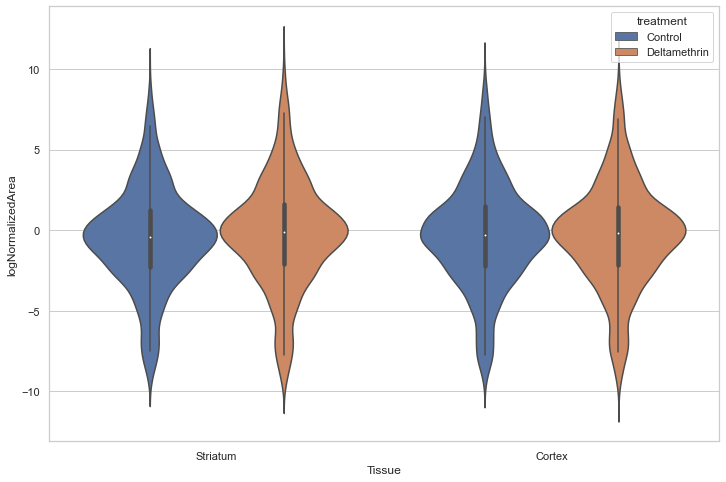

In [9]:
fig100 = plt.figure(figsize=(12,8))
ax = sns.violinplot(data=data, x='tissue', hue='treatment', y='logNormalizedArea')
ax.set_xlabel('Tissue')

fig100.savefig(os.path.join(data_path,"violinplot-tissue.svg"), format='svg', facecolor='w')

plt.show()

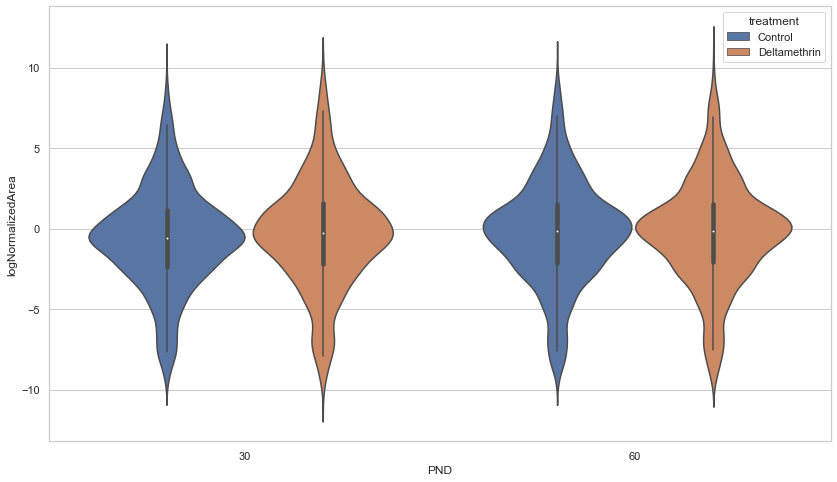

In [10]:
fig = plt.figure(figsize=(14,8))
ax = sns.violinplot(data=data, x='pnd', hue='treatment', y='logNormalizedArea')
ax.set_xlabel('PND')
                    
fig.savefig(os.path.join(data_path,"violinplot-pnd.svg"), format='svg', facecolor='w')

plt.show()

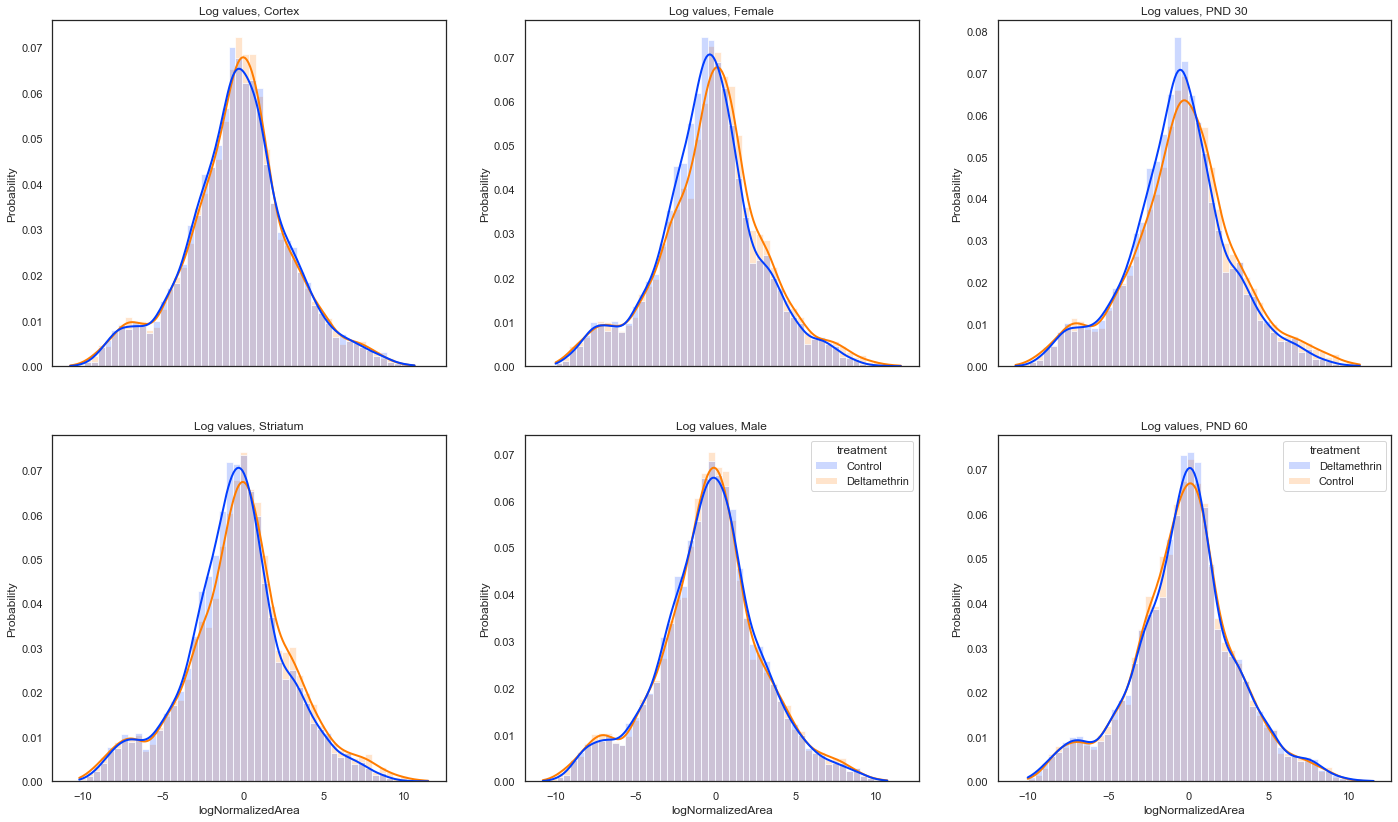

In [11]:
sns.set_style('white')

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[data['tissue'] == 'Cortex'], x='logNormalizedArea', hue='treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Cortex')
sns.histplot(data=data[data['tissue'] == 'Striatum'], x='logNormalizedArea', hue='treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum')

sns.histplot(data=data[data['gender'] == 'Female'], x='logNormalizedArea', hue='treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Female')
sns.histplot(data=data[data['gender'] == 'Male'], x='logNormalizedArea', hue='treatment', ax=ax[1,1], legend=True, **opt)
ax[1,1].set_title('Log values, Male')

sns.histplot(data=data[data['pnd'] == 30], x='logNormalizedArea', hue='treatment', ax=ax[0,2], legend=False, **opt)
ax[0,2].set_title('Log values, PND 30')
sns.histplot(data=data[data['pnd'] == 60], x='logNormalizedArea', hue='treatment', ax=ax[1,2], legend=True, **opt)
ax[1,2].set_title('Log values, PND 60')

fig.savefig(os.path.join(data_path,"distribution-3cases.svg"), format='svg', facecolor='w')

plt.show()

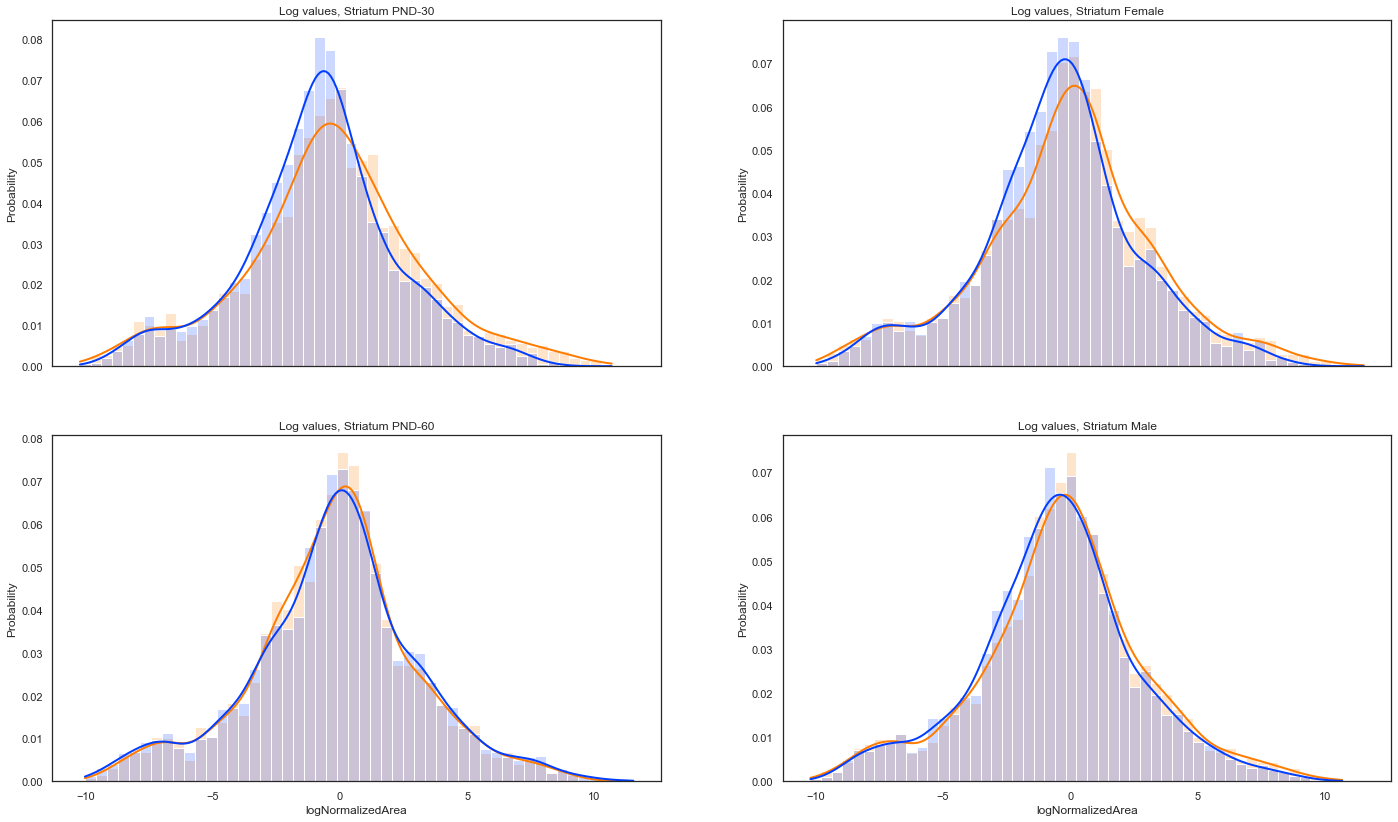

In [12]:
sns.set_style('white')

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[(data['tissue'] == 'Striatum') & (data['pnd'] == 30)], x='logNormalizedArea', hue='treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Striatum PND-30')
sns.histplot(data=data[(data['tissue'] == 'Striatum') & (data['pnd'] == 60)], x='logNormalizedArea', hue='treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum PND-60')

sns.histplot(data=data[(data['tissue'] == 'Striatum') & (data['gender'] == 'Female')], x='logNormalizedArea', hue='treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Striatum Female')
sns.histplot(data=data[(data['tissue'] == 'Striatum') & (data['gender'] == 'Male')], x='logNormalizedArea', hue='treatment', ax=ax[1,1], legend=False, **opt)
ax[1,1].set_title('Log values, Striatum Male')

fig.savefig(os.path.join(data_path,"distribution-Striatum-2cases.svg"), format='svg', facecolor='w')

plt.show()

# Statistics

## Wilcoxon test applied on the data with no normalization

#### Data divided by tissue

In [13]:
tissue = ['Striatum','Cortex']
gender = ['Female', 'Male']
pnd = [30,60]
var_name = 'normalizedArea'


for t in tissue:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['tissue']==t)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['tissue']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ranksums(a,b).pvalue:.2e}')

Tissue: Striatum. P-value: 2.73e-10
Tissue: Cortex. P-value: 5.16e-01


#### Data divided by gender

In [14]:
for g in gender:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['gender']==g)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['gender']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ranksums(a,b).pvalue:.2e}')

Gender: Female. P-value: 8.37e-12
Gender: Male. P-value: 8.43e-01


#### Data divided by PND

In [15]:
for p in pnd:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['pnd']==p)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['pnd']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 1.18e-08
PND: 60. P-value: 7.67e-01


## T-test applied on the data with log normalization

#### Data divided by tissue

In [16]:
var_name = 'logNormalizedArea'

for t in tissue:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['tissue']==t)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['tissue']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Tissue: Striatum. P-value: 3.43e-08
Tissue: Cortex. P-value: 7.96e-01


#### Data divided by gender

In [17]:
for g in gender:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['gender']==g)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['gender']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Gender: Female. P-value: 1.06e-08
Gender: Male. P-value: 9.15e-01


#### Data divided by PND

In [18]:
for p in pnd:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['pnd']==p)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['pnd']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 1.18e-08
PND: 60. P-value: 7.67e-01


## Three-way ANOVA on log normalized data

#### Quelli singoli sono mediati su tutto il resto. Mentre l'effetto del secondo oridne dice che è vero che partono da livelli differenti diversi striato e corteccia, ma l'effetto del trattamento ha effetto anche se loro sono già diversi

In [19]:
model = ols('logNormalizedArea ~ C(gender) + C(treatment) + C(tissue) + C(gender):C(treatment) + C(tissue):C(treatment)', data=data_normalized).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),9.039819,1.0,0.852519,0.355848
C(treatment),178.285612,1.0,16.813605,0.000041
C(tissue),6.381465,1.0,0.601818,0.437891
C(gender):C(treatment),163.789708,1.0,15.446538,0.000085
C(tissue):C(treatment),146.460044,1.0,13.812227,0.000202
Residual,332541.126817,31361.0,NaN,NaN


In [20]:
model = ols('logNormalizedArea ~ C(gender) + C(pnd) + C(treatment) + C(tissue) + C(pnd):C(treatment) + C(gender):C(treatment) + C(tissue):C(treatment)', data=data_normalized).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),7.618615,1.0,0.719423,0.396340
C(pnd),231.997755,1.0,21.907464,0.000003
C(treatment),117.680768,1.0,11.112552,0.000858
C(tissue),6.948416,1.0,0.656136,0.417933
C(pnd):C(treatment),220.600204,1.0,20.831198,0.000005
C(gender):C(treatment),160.789093,1.0,15.183256,0.000098
C(tissue):C(treatment),142.819208,1.0,13.486366,0.000241
Residual,332088.528858,31359.0,NaN,NaN


### Anova only striatum

In [21]:
data_striatum = data_normalized[data_normalized['tissue'] == 'Striatum'].copy(deep=True)

In [22]:
model = ols('logNormalizedArea ~ C(gender) + C(treatment)  + C(gender):C(treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),89.734457,1.0,8.427262,3.701481e-03
C(treatment),323.772635,1.0,30.406568,3.558374e-08
C(gender):C(treatment),11.147504,1.0,1.046899,3.062380e-01
Residual,168123.086917,15789.0,NaN,NaN


In [23]:
model = ols('logNormalizedArea ~ C(gender) + C(pnd) + C(treatment)+ C(pnd):C(treatment) + C(gender):C(treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),75.449091,1.0,7.110036,7.673166e-03
C(pnd),358.776000,1.0,33.809691,6.194938e-09
C(treatment),145.871980,1.0,13.746423,2.099348e-04
C(pnd):C(treatment),238.473536,1.0,22.472842,2.149959e-06
C(gender):C(treatment),14.597796,1.0,1.375641,2.408627e-01
Residual,167525.837381,15787.0,NaN,NaN


# Heatmap

Index(['componentGroupName', 'sampleNameOnTube', 'treatment',
       'injectionVolume', 'expectedRt', 'area', 'isArea', 'areaRatio',
       'retentionTime', 'signalNoise', 'tissueWeightMg', 'normalizedArea',
       'pnd', 'sampleName', 'isNormalizationFactor', 'normfactor',
       'logNormalizedArea', 'logAreaRatio'],
      dtype='object')


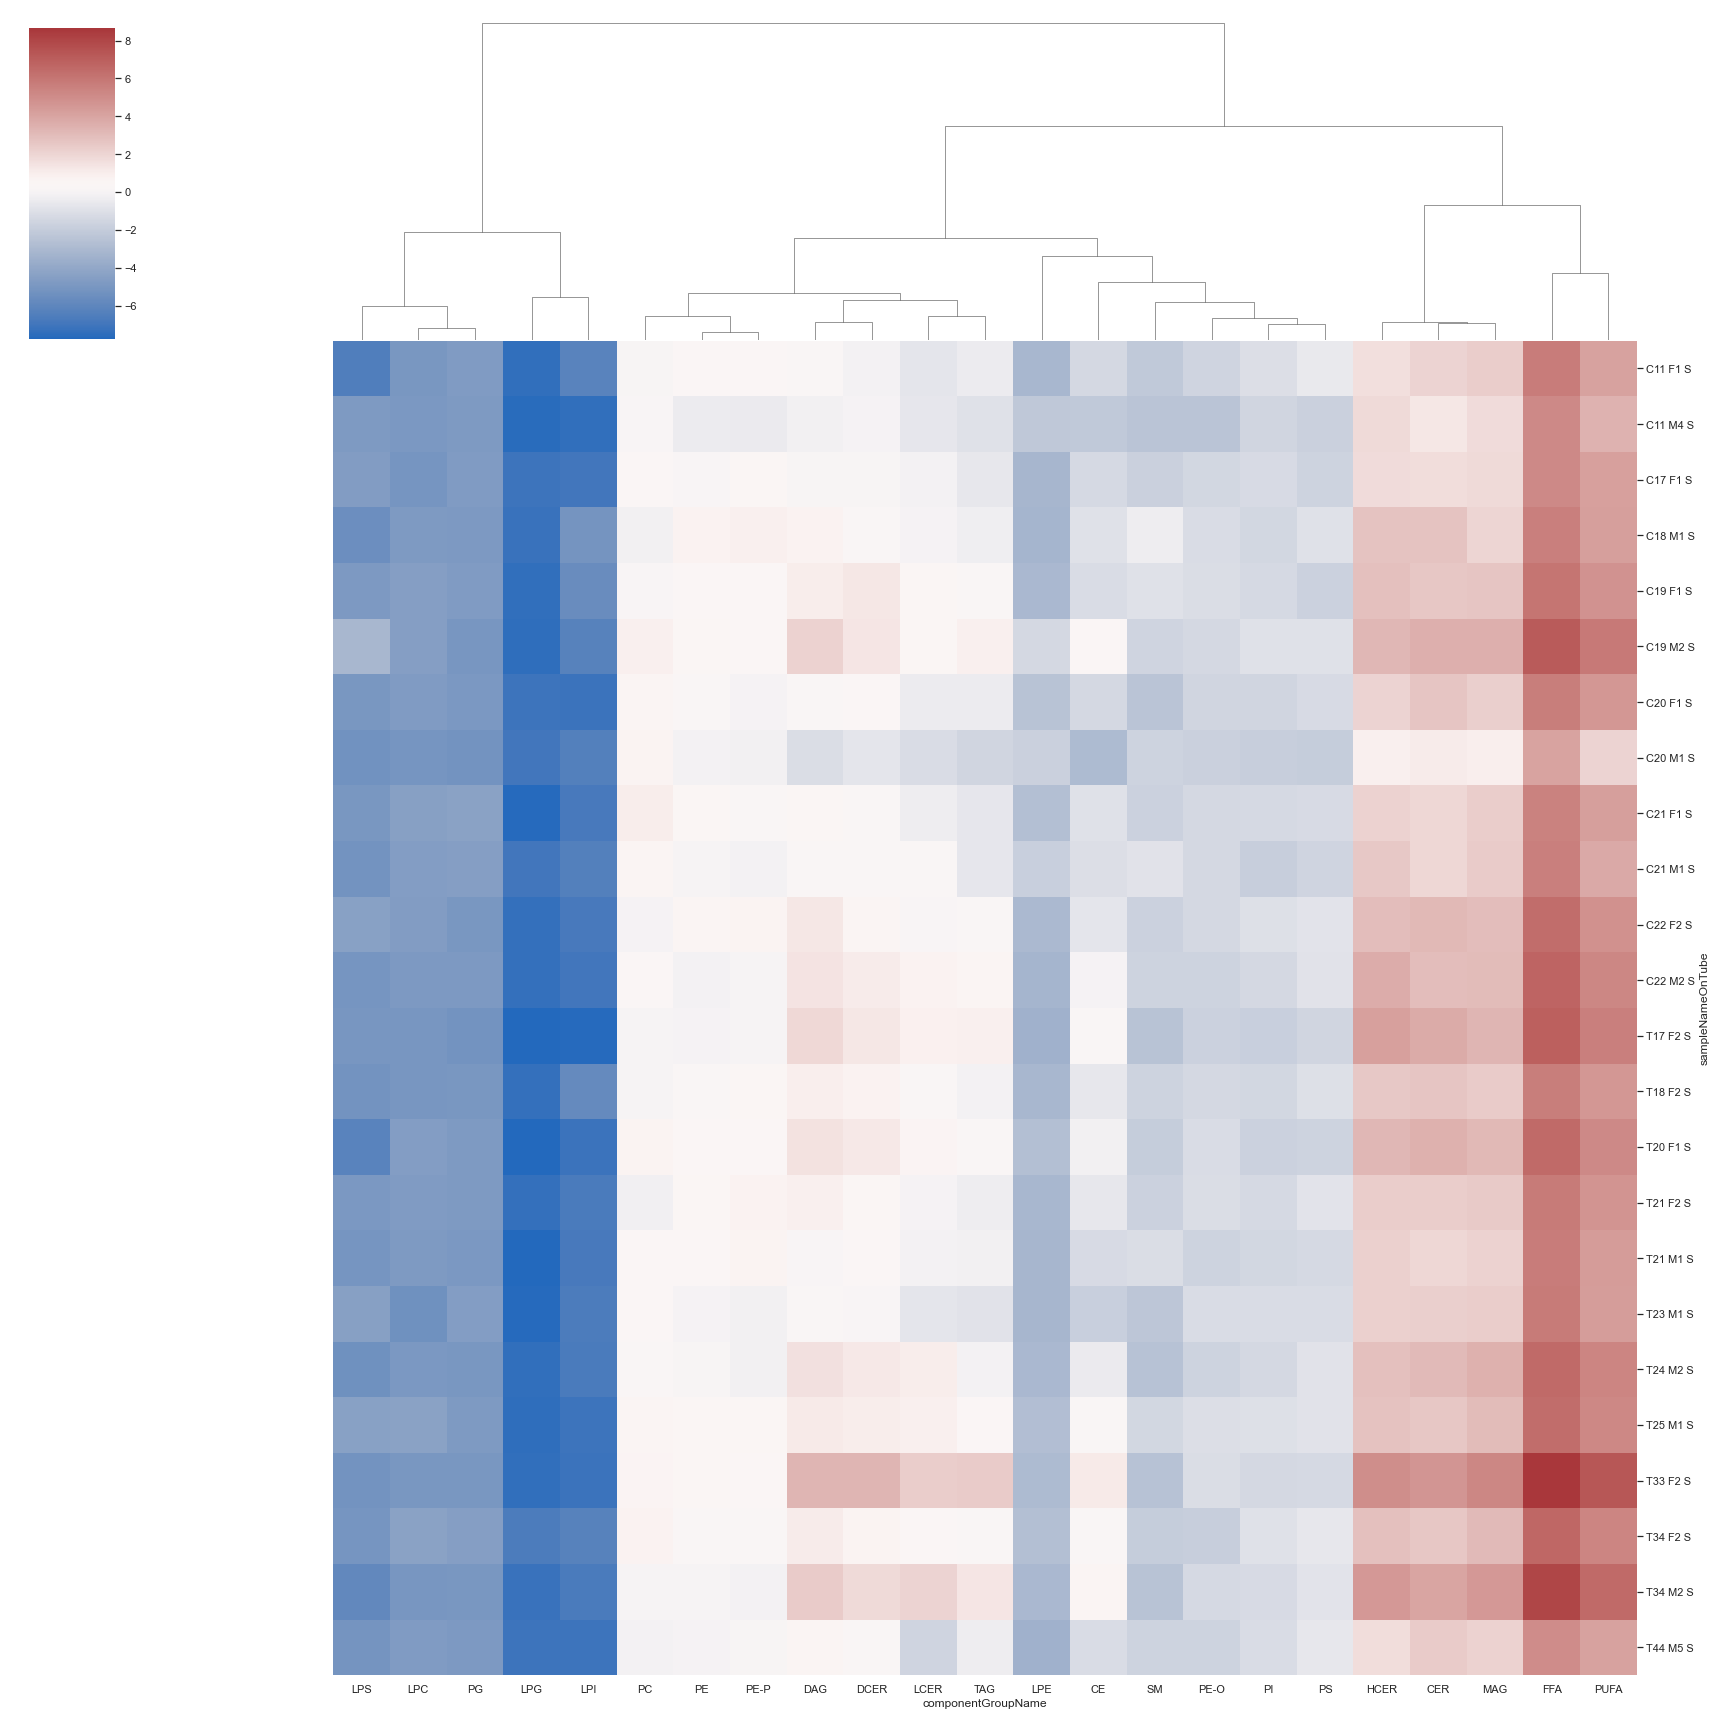

In [24]:
data_grouped = data_striatum.groupby(by=['componentGroupName','sampleNameOnTube']).median().reset_index()
data_grouped.insert(2,'treatment',['Control' if x[0] == 'C' else 'Deltamethrin' for x in data_grouped.iloc[:,1]])
data_grouped.sort_values(by='sampleNameOnTube',inplace=True)
print(data_grouped.columns)
pivot_kws=[
        'sampleNameOnTube',
        'componentGroupName',
        'logNormalizedArea'
]
data_pivot = data_grouped.pivot(*pivot_kws).sort_index()

lut = dict(zip(np.unique([x[0] for x in data_pivot.index]),'rg'))
treatment = pd.Series([x[0] for x in data_pivot.index])
col_colors = treatment.map(lut)
ax = sns.clustermap(data=data_pivot,
        row_cluster=False,
        # row_colors=col_colors,
        figsize=(24,24),cmap='vlag')

ax.figure.savefig(os.path.join(data_path,"test.svg"),format="svg",facecolor="w")

plt.show()

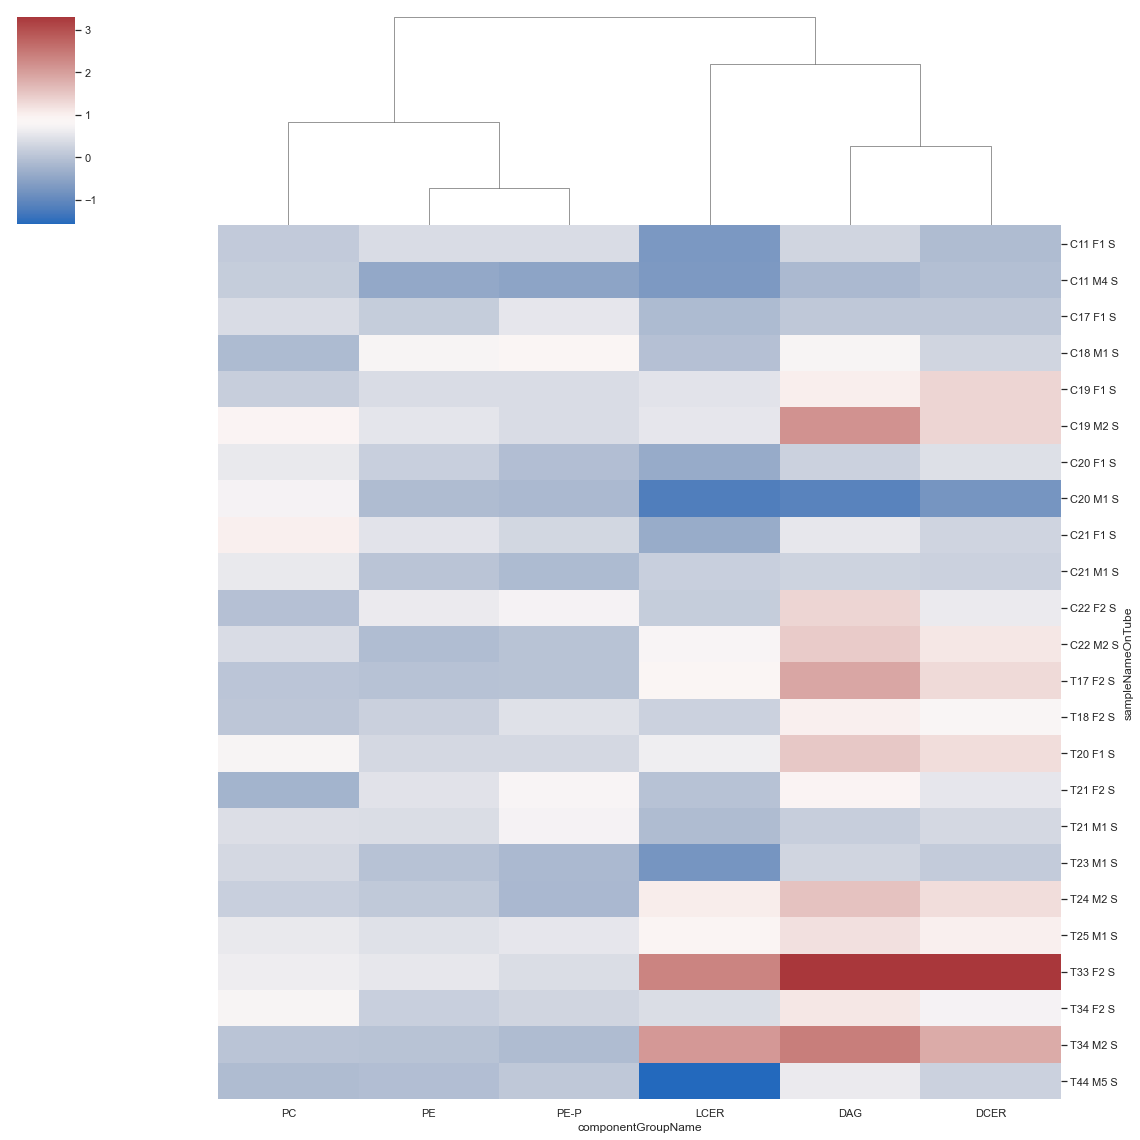

In [25]:
cgn_selected = ['PC','PE','PE-P','DAG','DCER','LCER',
    # 'TAG','LPE','CE','SM','PE-O','PI','PS'
    ]
data_pivot_selected = data_pivot[cgn_selected]
sns.clustermap(data=data_pivot_selected,
        row_cluster=False,
        figsize=(16,16),cmap='vlag')
plt.show()

# Single lipids statistics

## Define lipids list

In [26]:
lipids_list = data_normalized['componentName'].unique()
print(lipids_list.shape[0])

800


## Test lipid

In [27]:
data_lipid = data_normalized[data_normalized['componentName'] == lipids_list[0]]

from scipy.stats import ttest_ind
multcomp = mc.MultiComparison(data_lipid['normalizedArea'], groups=data_lipid['treatment'])
res = multcomp.allpairtest(ttest_ind)[1][2][0]
print(res)
res = multcomp.allpairtest(ttest_ind)[0]
print(res)

0.004413131135827457
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
 group1    group2     stat   pval  pval_corr reject
---------------------------------------------------
Control Deltamethrin 2.9946 0.0044    0.0044   True
---------------------------------------------------


## Analysis control vs treatment

In [44]:
import itertools
factor = 'treatment'
results_all = []
for l in lipids_list:
    data_lipid = data_normalized[data_normalized['componentName'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['normalizedArea'].values
            b = data_lipid[data_lipid[factor] == c[1]]['normalizedArea'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            cd = np.abs((np.mean(a) - np.mean(b)))
            cd /= np.sqrt(
                ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)
            )
            n_samples = a.size
            sp = TTestIndPower().power(effect_size=cd, nobs1=n_samples, alpha=0.05)
            results_all.append([l, fc, pvalue, c[0], c[1], cd, n_samples, sp])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2', 'effectSize', 'sampleSize', 'statisticalPower']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\smran\AppData\Local\Temp/ipykernel_17036/1692271233.py:14: RuntimeWarning: invalid value encountered in double_scalars
  ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)


,lipid,fc,p,treatment1,treatment2,effectSize,sampleSize,statisticalPower
0,SM(14:0)+H,1.266870,0.004413,Control,Deltamethrin,0.883059,24,0.849571
1,SM(16:0)+H,1.149201,0.133881,Control,Deltamethrin,0.449964,24,0.332482
2,SM(18:0)+H,1.051935,0.726303,Control,Deltamethrin,0.103856,24,0.064337
3,SM(18:1)+H,1.108338,0.133920,Control,Deltamethrin,0.449918,24,0.332425
4,SM(20:0)+H,1.009640,0.970390,Control,Deltamethrin,0.011006,24,0.050160


### Statistical power with average effectSize

In [68]:
es_mean = np.median(results_all['effectSize'][results_all['p']<0.05])
# es_mean = 0.8
print(es_mean)
n_mice = 24
statisticalPower = TTestIndPower().power(effect_size=es_mean, nobs1=n_mice, alpha=0.05)
print(statisticalPower)

0.7501306084530086
0.7203904735086241


### Given an effect size, and a statistical power, determine n_mice

In [66]:
es_mean = 0.7
alpha = 0.05
statisticalPower = 0.8
n_mice_ideal = TTestIndPower().solve_power(effect_size=es_mean, alpha=alpha, power=statisticalPower)
print(n_mice_ideal)

33.024569515862694


## Plots

In [29]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break 

In [30]:
def plot_volcano(results_all, fc_threshold=0.3, pvalue_threshold=1.5):
    
    col = np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k'))

    fig = plt.figure(figsize=(14,12))
    plt.scatter(np.log2(results_all['fc']), -np.log10(results_all['p']), c=col)
    shownlabels = []
    l_ha = ['right','left']

    for i in range(results_all.shape[0]): 

        x = np.log2(results_all.iloc[i]['fc'])
        y = -np.log10(results_all.iloc[i]['p'])
        aa = np.random.rand()*3 - 1.5 + 0.5 * np.sign(x)
        ii = np.sign(aa) * 0.5 + 0.5
        if (np.abs(x) > fc_threshold) and (y > pvalue_threshold):
            l = plt.text(x+0.1*aa, y, 
                         results_all.iloc[i]['lipid'],ha=l_ha[int(ii)], va='center', color='k', 
                         fontsize=10, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
            shownlabels.append(l)

    #adjustlabels(fig, shownlabels)

    plt.xlabel('log FC',)
    plt.ylabel('-log10 (Pvalue)')
    plt.rc('axes', labelsize=18) 

    plt.show()

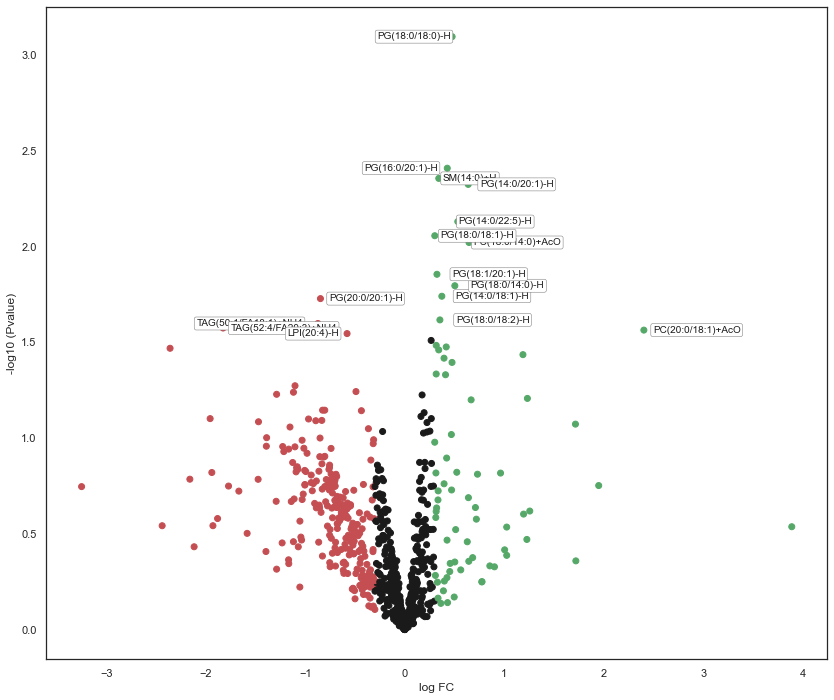

In [31]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=1.5)

## Analysis striatum vs cortex

In [32]:
factor = 'tissue'
results_all = []
for l in lipids_list:
    data_lipid = data_normalized[data_normalized['componentName'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['normalizedArea'].values
            b = data_lipid[data_lipid[factor] == c[1]]['normalizedArea'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv('tissue_treatment.csv')

c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


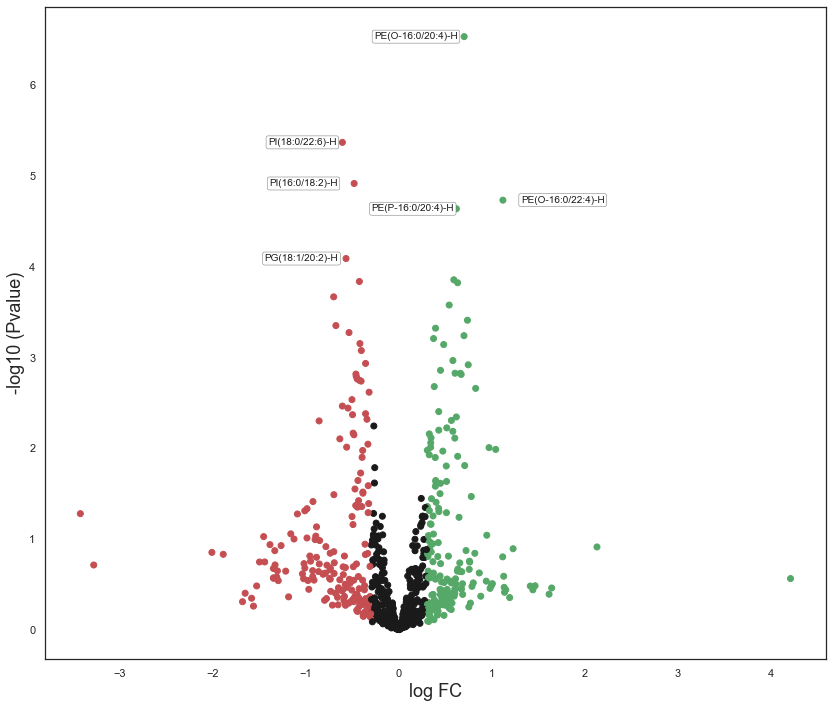

In [33]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=4)

## Analysis 30 vs 60

In [34]:
factor = 'pnd'
results_all = []
for l in lipids_list:
    data_lipid = data_normalized[data_normalized['componentName'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['normalizedArea'].values
            b = data_lipid[data_lipid[factor] == c[1]]['normalizedArea'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv('pnd_treatment.csv')

c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


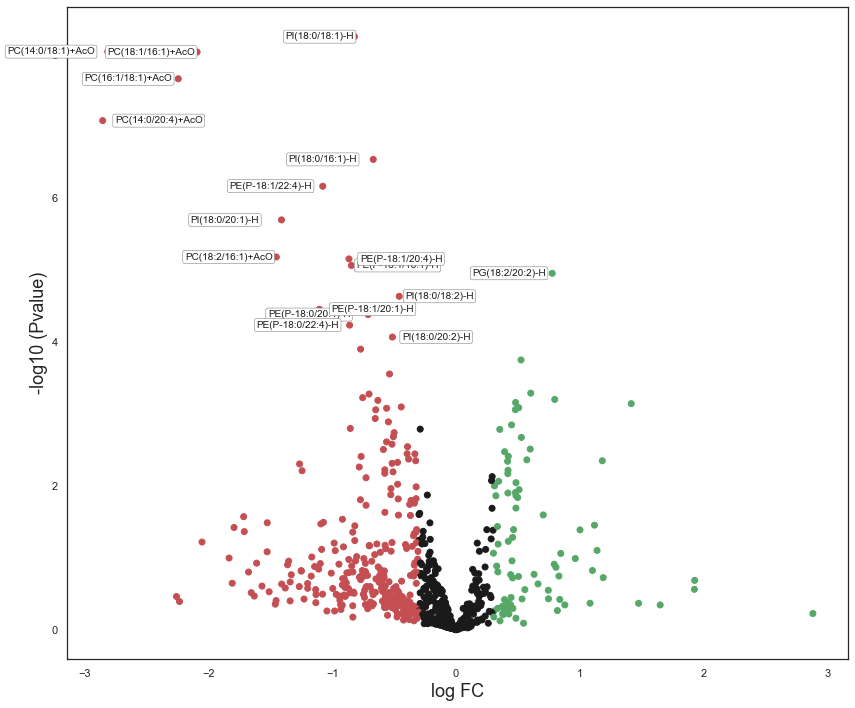

In [35]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=4)

## Analysis male vs female

In [36]:
factor = 'gender'
results_all = []
for l in lipids_list:
    data_lipid = data_normalized[data_normalized['componentName'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['normalizedArea'].values
            b = data_lipid[data_lipid[factor] == c[1]]['normalizedArea'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv('sex_treatment.csv')

c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


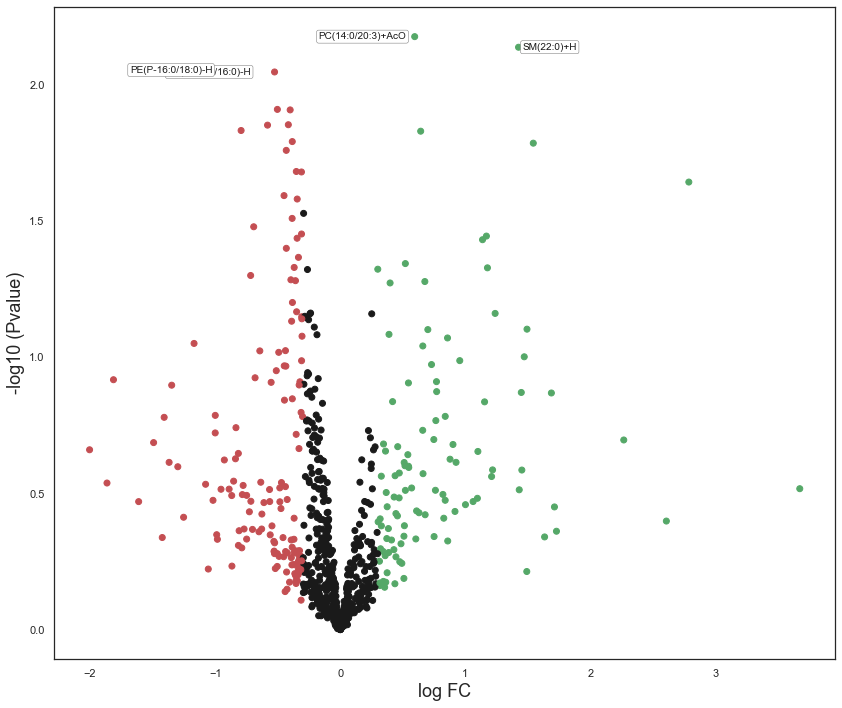

In [37]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=2)